In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
import absorption_line_vel as vel
from absorption_line_vel import SpectrumSN_Lines, AbsorbLine

# read spec data
z = 0.0307
spec = '../../spectroscopy/ZTF20aayhacx_20200623_Keck1_v1.ascii'
Spec1 = SpectrumSN_Lines(spec, z)
Spec = SpectrumSN_Lines(spec, 0)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'

# 20200623_Keck1

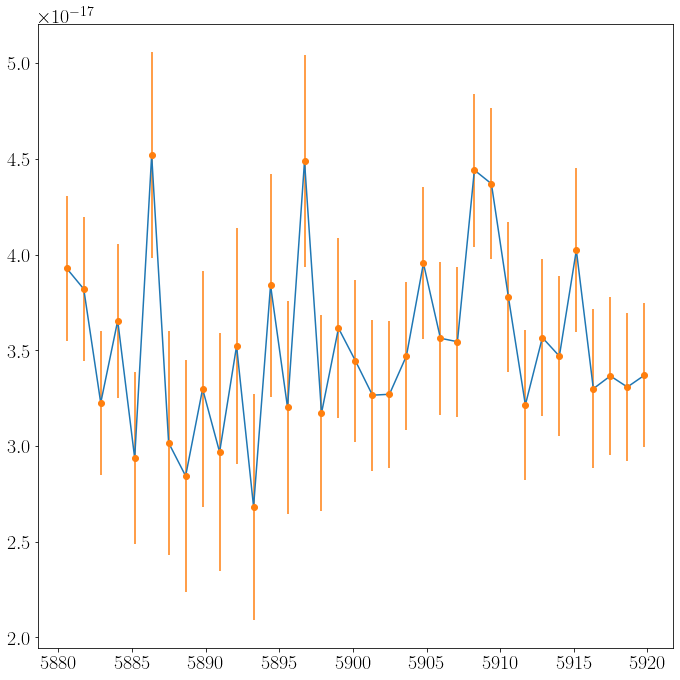

In [4]:
Spec.plot_line_region(5880, 5920)

In [74]:
Spec.add_line('NaI_5896', 5875, 5905, lines=[5889.950, 5895.924], rel_strength=[2, 1])

26 points within 5875.00 and 5905.00 angstroms.


../absorption_line_vel.py:149: UserWarning: <=5 points within the wavelength range!
  warnings.warn(


  9%|▉         | 4500/50000 [02:00<20:16, 37.39it/s]  


MCMC results:
Velocity pvf: -42 pm 95 km/s


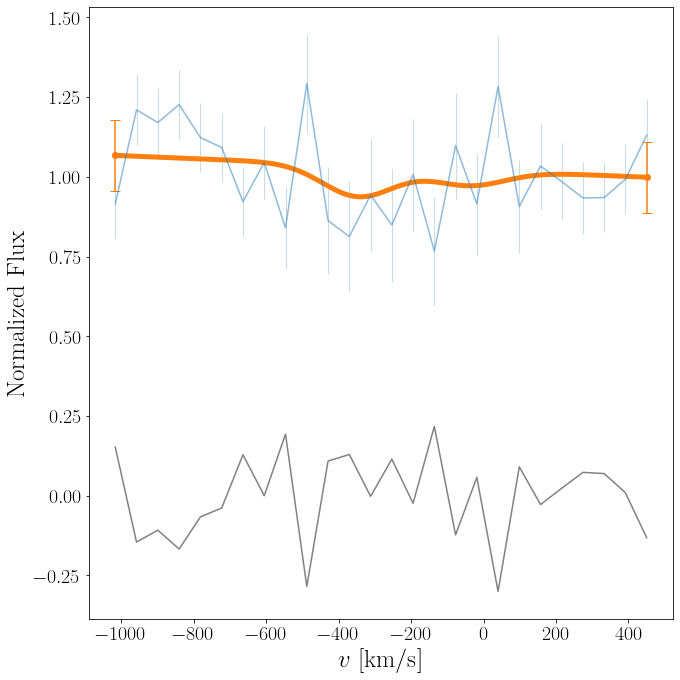

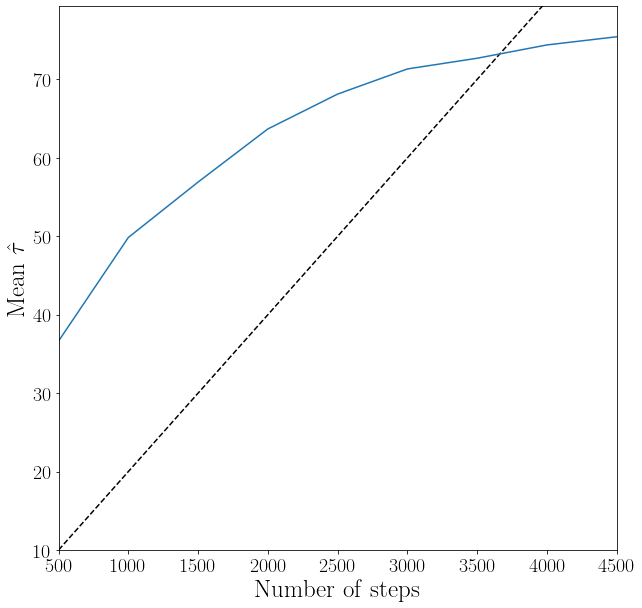

In [75]:
'''sampler = Spec.line['NaI_5896'].MCMC_sampler(initial=[1, 1, -100, 3, -5],
                                             normalize_unc=False,
                                             max_nsteps=1000)'''

sampler = Spec.line['NaI_5896'].MCMC_sampler(
    vel_flat=[-350, 350],
    var_max=1e4,
    initial=[1, 1, 0, 8, -5],
    normalize_unc=False,
    #Plot_mcmc=True,
    Plot_tau=True)

In [77]:
sample = sampler.get_chain(discard=700, flat=True, thin=1)
logprob = sampler.get_log_prob(discard=700, flat=True, thin=1)

Na = Spec.line['NaI_5896']
ratio = 2 / (Na.red_vel - Na.blue_vel) / (Na.red_fl[0]+Na.blue_fl[0])*\
            (Na.wv_line[-1] - Na.wv_line[0]) * np.sum(Na.rel_strength) * 1000
sig = np.exp(sample[:, -2] / 2)
EW = sample[:, -1] * -ratio
hist, bin_edges = np.histogram(EW, bins=100, density=True)
bins = (bin_edges[1:] + bin_edges[:-1]) / 2
width = bin_edges[1] - bin_edges[0]
arg = np.argsort(hist)

cred = 0.68  # credible region
dens_thres = np.inf
j = 0
while cred > 0:
    cred -= width * hist[arg[-1 - j]]
    dens_thres = hist[arg][-1 - j]
    j += 1
interval68 = bins[hist > dens_thres]

cred = 0.95-0.68  # credible region
while cred > 0:
    cred -= width * hist[arg[-1 - j]]
    dens_thres = hist[arg][-1 - j]
    j += 1
interval95 = bins[hist > dens_thres]

p1 = interval68[-1]
p2 = interval95[-1]

In [46]:
EBV1 = lambda EW: (2.47 * EW / 1000 - 1.76)
EBV2 = lambda EW: (2.16 * EW / 1000 - 1.91)
EBV = lambda EW: (1.17 * EW / 1000 - 1.85)

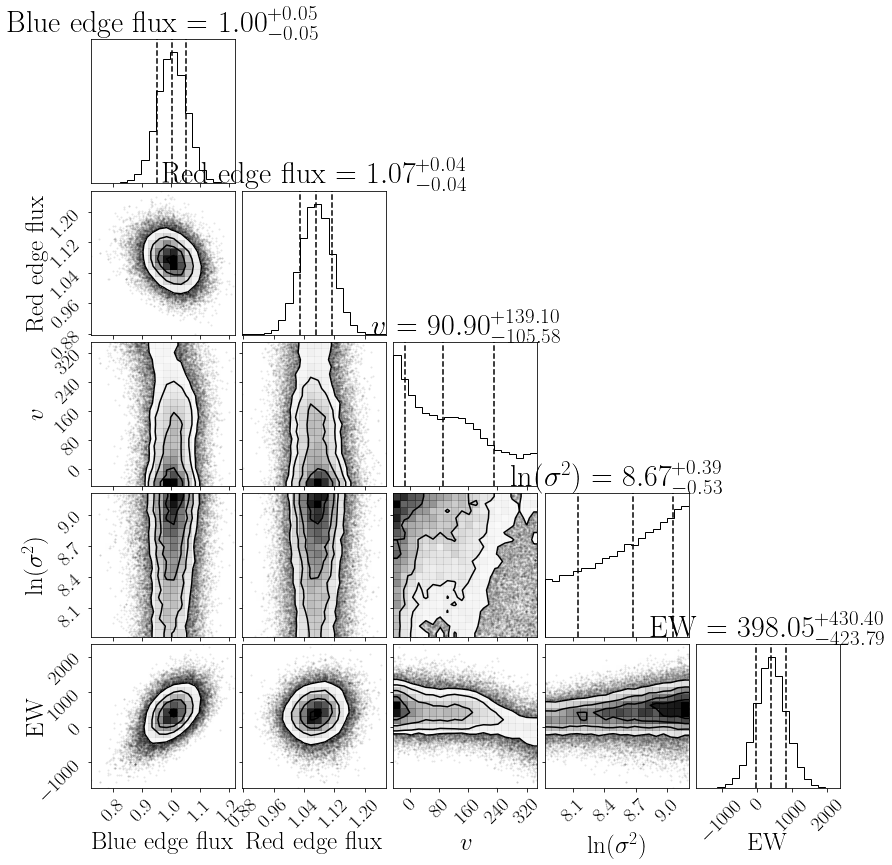

In [78]:
import corner
paramsNames = [
    r'$\mathrm{Blue\ edge\ flux}$', r'$\mathrm{Red\ edge\ flux}$', r'$v$',
    r'$\ln(\sigma^2)$', r'$\mathrm{EW}$'
]
chain = sample.copy()
chain[:, -1] = -ratio * chain[:, -1]
fig = corner.corner(chain[::7],
                    labels=paramsNames,
                    quantiles=[0.16, 0.50, 0.84],
                    show_titles=True)

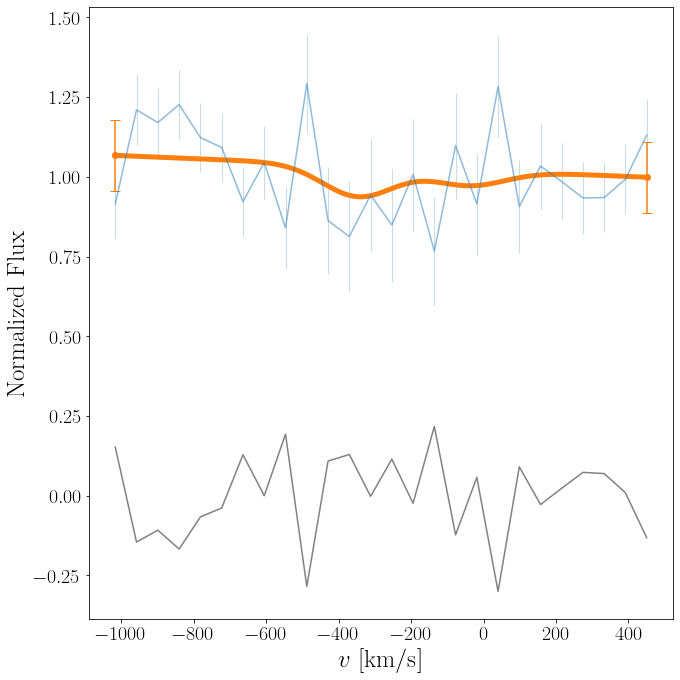

sigma = 99.3, EW = 446.9, E(B-V) = 0.047


In [79]:
the = Na.theta_MCMC.copy()
Na.plot_model(the)
print('sigma = {:.1f}, EW = {:.1f}, E(B-V) = {:.3f}'.format(
    np.exp(the[-2] / 2), -ratio * the[-1], 10**EBV(-ratio * the[-1])))

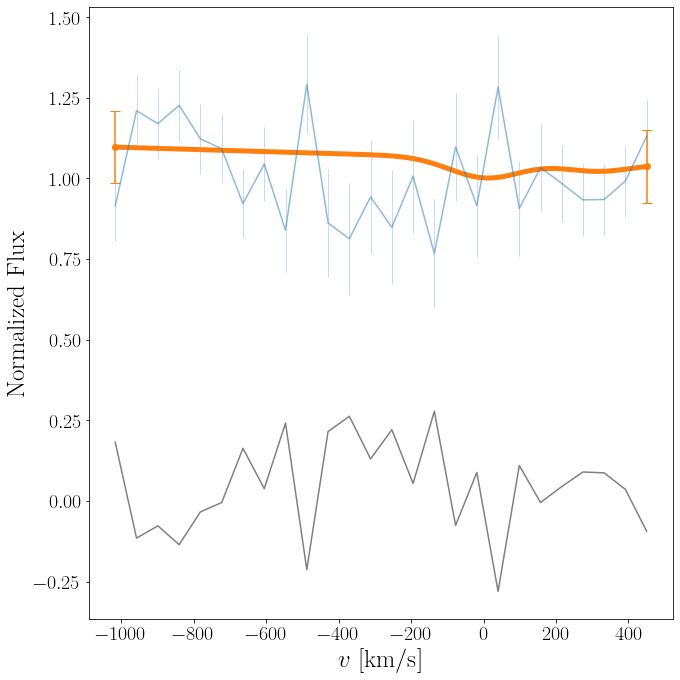

sigma = 100.0, EW = 283.0, E(B-V) = 0.030


In [80]:
the = sample[np.argmin(np.abs(sig - 100))]
Na.plot_model(the)
print('sigma = {:.1f}, EW = {:.1f}, E(B-V) = {:.3f}'.format(
    np.exp(the[-2] / 2), -ratio * the[-1], 10**EBV(-ratio * the[-1])))

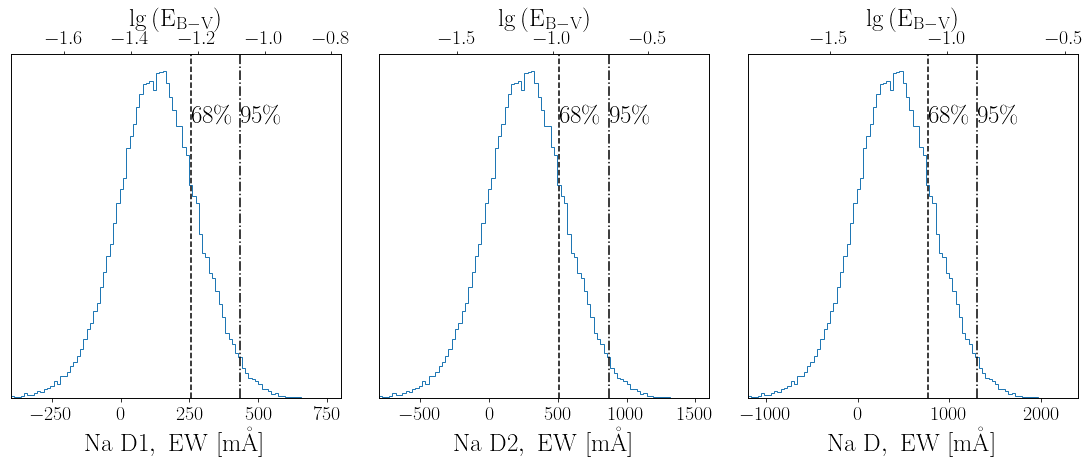

In [81]:
f, ax = plt.subplots(1, 3, figsize=(16, 7), sharey=True)
Range = 400
ax[0].axvline(p1 / 3, color='k', linestyle='--')
ax[0].axvline(p2 / 3, color='k', linestyle='-.')
ax[0].text(p1 / 3 / Range / 3 + 1 / 3,
           0.8,
           r'$68\%$',
           transform=ax[0].transAxes)
ax[0].text(p2 / 3 / Range / 3 + 1 / 3,
           0.8,
           r'$95\%$',
           transform=ax[0].transAxes)
ax[0].hist(EW / 3, histtype='step', bins=100, range=[-Range, Range * 2])
ax[0].set_xlabel(r'$\mathrm{Na\ D1,\ EW}\ [\mathrm{m\mathring{A}}]$')
ax02 = ax[0].twiny()
ax02.set_xlabel(r'$\lg\left(\mathrm{E_{\mathrm{B}-\mathrm{V}}}\right)$')
ax[0].set_xlim(-Range, Range * 2)
ax02.set_xlim(EBV1(0), EBV1(Range))

ax[1].axvline(p1 * 2 / 3, color='k', linestyle='--')
ax[1].axvline(p2 * 2 / 3, color='k', linestyle='-.')
ax[1].text(p1 / 3 / Range / 3 + 1 / 3,
           0.8,
           r'$68\%$',
           transform=ax[1].transAxes)
ax[1].text(p2 / 3 / Range / 3 + 1 / 3,
           0.8,
           r'$95\%$',
           transform=ax[1].transAxes)
ax[1].hist(EW * 2 / 3,
           histtype='step',
           bins=100,
           range=[-Range * 2, Range * 4])
ax[1].set_xlabel(r'$\mathrm{Na\ D2,\ EW}\ [\mathrm{m\mathring{A}}]$')
ax12 = ax[1].twiny()
ax12.set_xlabel(r'$\lg\left(\mathrm{E_{\mathrm{B}-\mathrm{V}}}\right)$')
ax[1].set_xlim(-Range * 2, Range * 4)
ax12.set_xlim(EBV2(0), EBV2(Range * 2))

ax[2].axvline(p1, color='k', linestyle='--')
ax[2].axvline(p2, color='k', linestyle='-.')
ax[2].text(p1 / 3 / Range / 3 + 1 / 3,
           0.8,
           r'$68\%$',
           transform=ax[2].transAxes)
ax[2].text(p2 / 3 / Range / 3 + 1 / 3,
           0.8,
           r'$95\%$',
           transform=ax[2].transAxes)
ax[2].hist(EW, histtype='step', bins=100, range=[-Range * 3, Range * 6])
ax[2].set_xlabel(r'$\mathrm{Na\ D,\ EW}\ [\mathrm{m\mathring{A}}]$')
ax22 = ax[2].twiny()
ax22.set_xlabel(r'$\lg\left(\mathrm{E_{\mathrm{B}-\mathrm{V}}}\right)$')
ax[2].set_xlim(-Range * 3, Range * 6)
ax22.set_xlim(EBV(0), EBV(Range * 3))

ax[0].set_yticks([])
f.tight_layout()

In [82]:
10**(EBV(p1)), 10**(EBV(p2))

(0.11093567010392205, 0.47299548104087413)

## Ca II IRT

<AxesSubplot:>

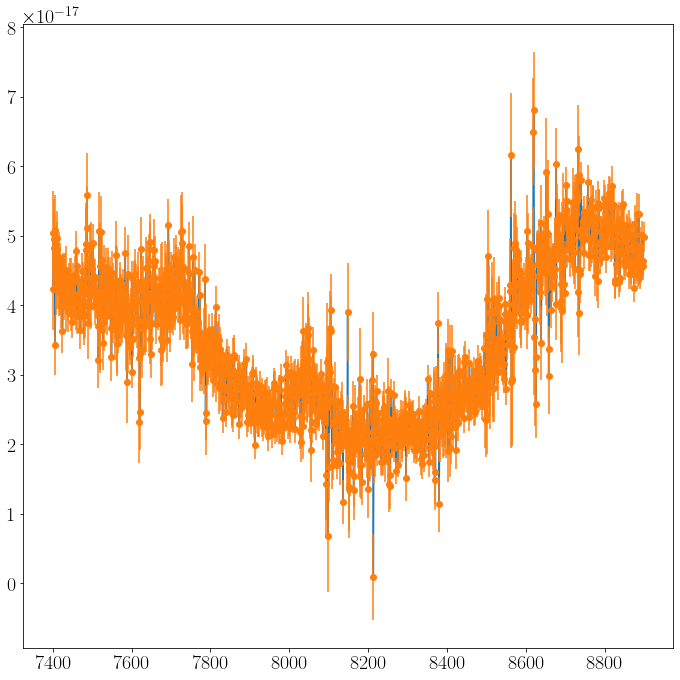

In [5]:
Spec1.plot_line_region(7400, 8900)

In [6]:
Spec1.add_line('CaII_IRT/CaII_IRT',
               7500,
               8800,
               lines=[[8498.018, 8542.089, 8662.140],
                      [8498.018, 8542.089, 8662.140]],
               rel_strength=[[], []])
Spec1.line['CaII_IRT/CaII_IRT'].LS_estimator(guess=(1, 1, -25000, 15, -1000,
                                                    -12000, 15, -1000))

1116 points within 7500.00 and 8800.00 angstroms.
LS estimation:
Velocity 1: -23898 km/s
Velocity 2: -9519 km/s


Normalize factor = 1.248


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 53.35it/s]


MCMC results:
Velocity 1: -23884 pm 189 km/s
Velocity 2: -9574 pm 193 km/s
Normalize factor = 1.252


  9%|███▍                                  | 4500/50000 [01:24<14:11, 53.42it/s]

MCMC results:
Velocity 1: -23855 pm 153 km/s
Velocity 2: -9567 pm 146 km/s


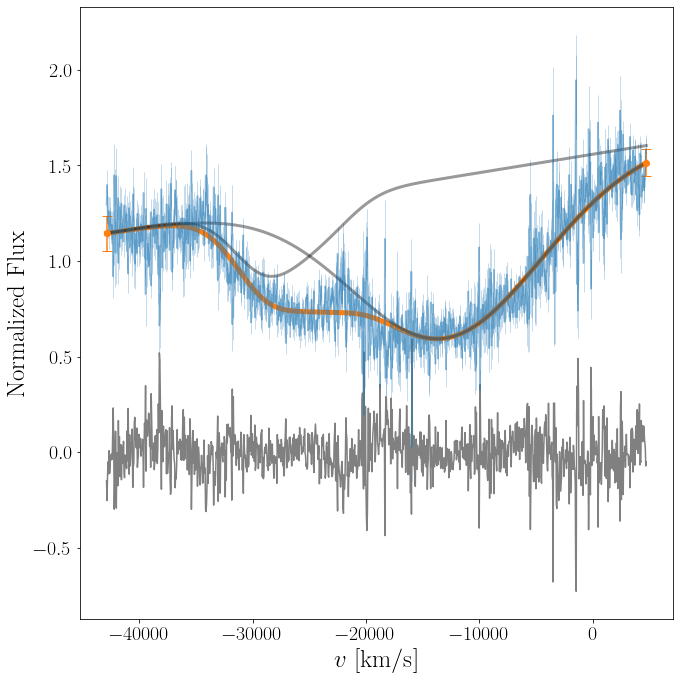

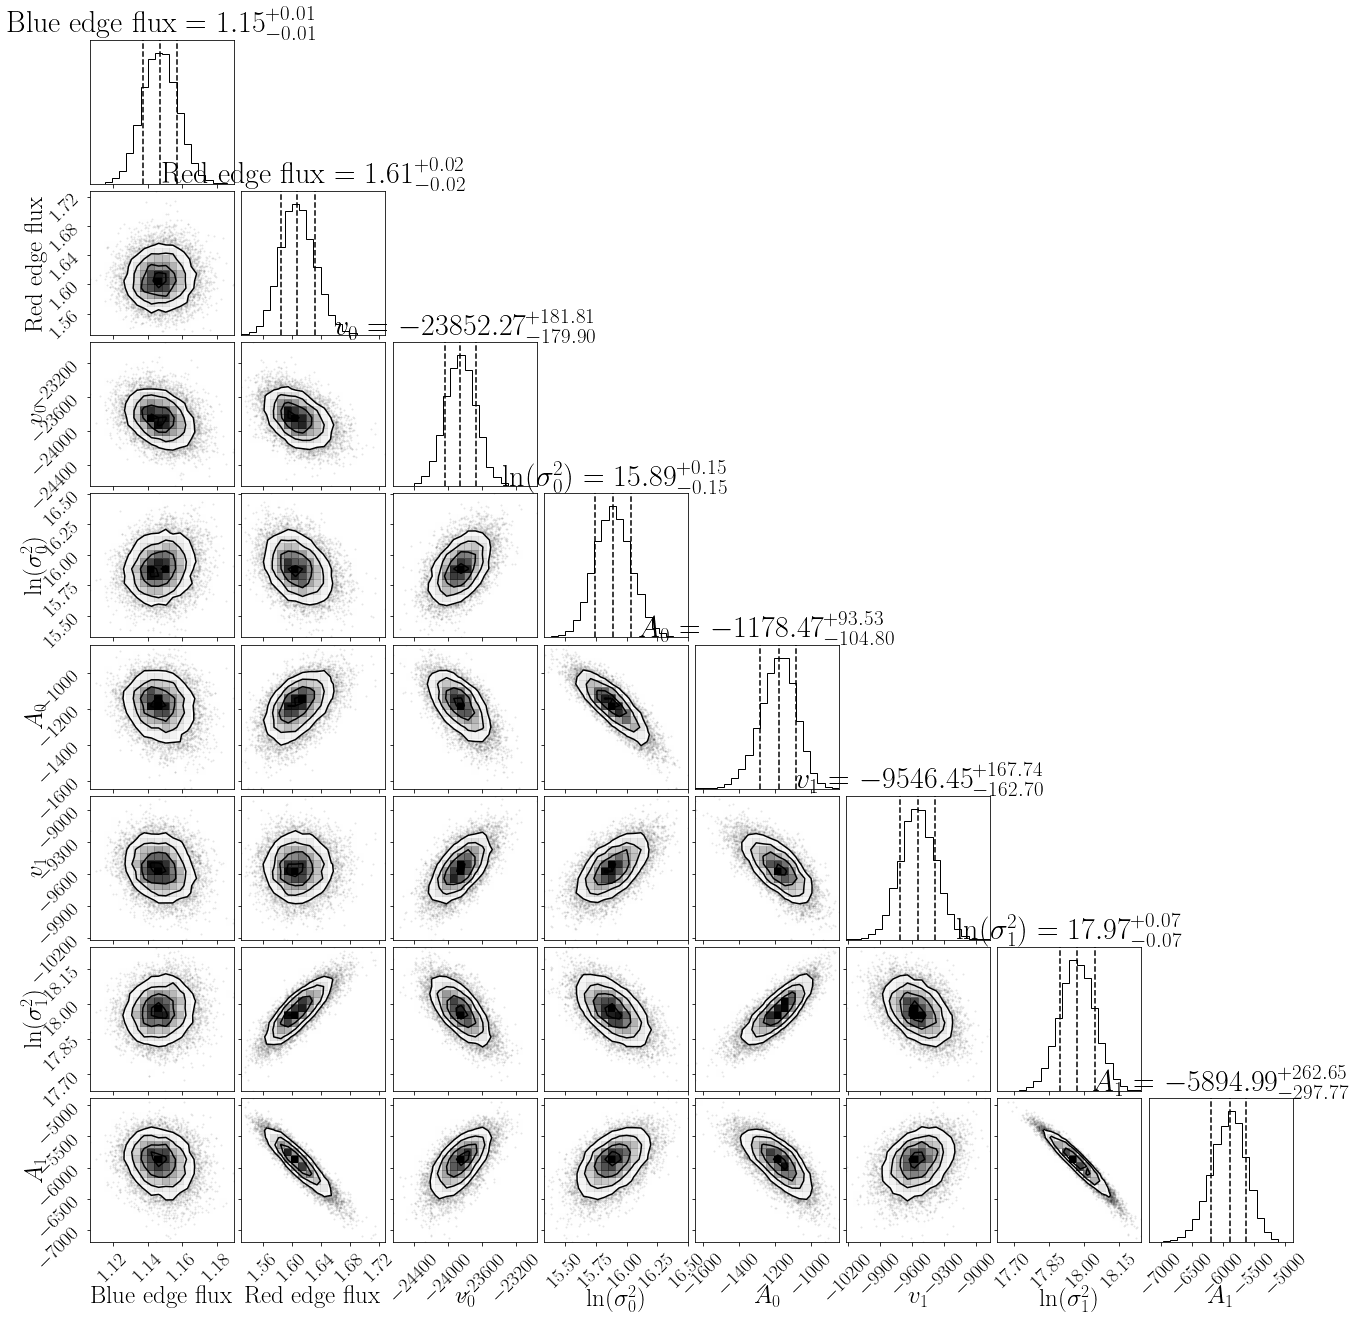

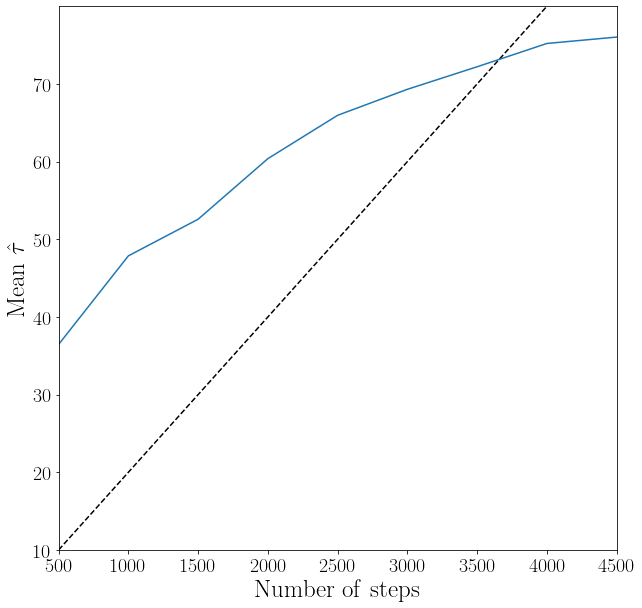

In [7]:
mu1 = -24000
mu2 = -11000
sampler = Spec1.line['CaII_IRT/CaII_IRT'].MCMC_sampler(
    mu_prior=[mu1, mu2],
    var_prior=[1e7, 1e7],
    initial=[1, 1, -25000, 15, -1000, -12000, 15, -1000],
    normalize_unc='LS',
    max_nsteps=1000,
    Plot_model=False)
sampler = Spec1.line['CaII_IRT/CaII_IRT'].MCMC_sampler(
    mu_prior=[mu1, mu2],
    var_prior=[1e7, 1e7],
    initial=Spec1.line['CaII_IRT/CaII_IRT'].theta_MCMC,
    normalize_unc='MCMC',
    Plot_mcmc=True,
    Plot_tau=True)